This notebook includes the codes used for the final project of the course of "Machine Learning for Earth and Environmental Sciences," instructed by Prof. Beucler, titled: "Deriving Lake Urmia water depth using Landsat 8 imagery and field
measurements."

In the first step, the packages containing the necessary functions are imported.

In [11]:
import pandas as pd
import os
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import tifffile 
import matplotlib.pyplot as plt

Then, the font of the texts in the plots and its size is set to be compatible with the whole report.

In [3]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})

Then, the data is loaded and set as a dataframe. The data includes 6426 observations (rows), in which the firts six columns are the input data (Landsat 8 bands 2 to 7) and the seventh band is the depth of each observation in meters. And then, the data is converted to nunmpy arrays and each input and output are saved separately.

In [4]:
df = pd.read_excel (os.path.join('input.xls'))
dataset = pd.DataFrame.to_numpy(df)

X = dataset[:, :-1]
y = dataset[:, -1]

normX = preprocessing.normalize(X)

In this section the histogram of the depth (output data) is plotted to have an idea of the input data.

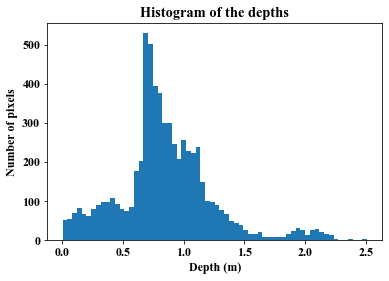

In [5]:

rng = np.random.RandomState()  # deterministic random data

np.histogram(y)

plt.hist(y, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of the depths")
plt.ylabel('Number of pixels')
plt.xlabel('Depth (m)')

plt.show()

Then the datasets is devided into training, validation, validation, and test datasets, using train_test_split function.
At first, the whole dataset is split into the test another set, respresenting both validation and training sets and then, the function is used to split the latter into validation and training sets.

In [6]:
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=1285.2/6426, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_t, y_t, test_size=1285.2/5140.8, random_state=42)

1. Linear regresssion

In this section, as the first methods, linear regression is used and then the r-squared and mean squared error of the training and test sets are determined.

In [12]:
#import sklearn.linear_model

model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)

print(r2_score(y_train, model.predict(X_train)), r2_score(y_test, model.predict(X_test)))
print(mean_squared_error(y_train, model.predict(X_train)), mean_squared_error(y_test, model.predict(X_test)))

0.5489400275684269 0.5313030702918069
0.06959009439959558 0.07150711078813365


2. Polynomial regression

Although the linear regression gives a rather low MSE, it is decided to use a more comlex model. 

Therefore, the input features are transfomed using the PolynomialFeatures function and then, are fit using linear regression.

In [12]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [13]:
X_t, X_test, y_t, y_test = train_test_split(X_poly, y, test_size=1285.2/6426, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_t, y_t, test_size=1285.2/5140.8, random_state=42)

In [103]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

print(r2_score(y_train, lin_reg.predict(X_train)), r2_score(y_test, lin_reg.predict(X_test)))
print(mean_squared_error(y_train, lin_reg.predict(X_train)), mean_squared_error(y_test, lin_reg.predict(X_test)))

0.6849022101378139 0.6615458333036843
0.048613679514512745 0.051636522581291054


3. Linear regression SVM

Moving from linear regression into polynomial linear regression, has increaed the r squared value. However, the result is not desireable. Therefore, I have decided to move to the next more complex method: Linear Regression SVM.

In [104]:
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_t, y_t, test_size=0.2, random_state=42)

In [105]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5)
svm_reg.fit(X_train, y_train)

print(r2_score(y_train, svm_reg.predict(X_train)), r2_score(y_test, svm_reg.predict(X_test)))
print(mean_squared_error(y_train, svm_reg.predict(X_train)), mean_squared_error(y_test, svm_reg.predict(X_test)))

-0.19058971409337366 -0.17348029664129072
0.1836856641220019 0.17903293207374701


The result of using the svm_reg is worse than the oter two previous methods! 

Therefore, I decided to use the SVR function instead and as based on the last results, the using polynomial features gives better results, I used a polynomial kernel with second degree.

In [13]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X_train, y_train)

print(r2_score(y_train, svm_poly_reg.predict(X_train)), r2_score(y_test, svm_poly_reg.predict(X_test)))
print(mean_squared_error(y_train, svm_poly_reg.predict(X_train)), mean_squared_error(y_test, svm_poly_reg.predict(X_test)))

0.6410626764967595 0.6324172459652317
0.05537729737239757 0.05608054811226552


As seen, using these parameters are able to give better results. However, I decided to use GridsearchCV to be able to find the best parameters.

In [81]:
from sklearn.model_selection import GridSearchCV

# Make sure the dataset is a square matrix if you are using kernel='precomputed'. Otherwise avoid using 'precomputed'.
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'C': [0.1, 1, 10],
    'epsilon': [0.001, 0.01, 0.1]# 'log2'],
    #'criterion' :['gini', 'entropy']
}

import time
start = time.time()
model = SVR()
reg = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5, verbose = 3)
reg.fit(X_train, y_train)
duration = time.time() - start
print(duration)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END C=0.1, degree=2, epsilon=0.001, kernel=linear;, score=0.275 total time=   0.2s
[CV 2/5] END C=0.1, degree=2, epsilon=0.001, kernel=linear;, score=0.267 total time=   0.2s
[CV 3/5] END C=0.1, degree=2, epsilon=0.001, kernel=linear;, score=0.288 total time=   0.2s
[CV 4/5] END C=0.1, degree=2, epsilon=0.001, kernel=linear;, score=0.276 total time=   0.2s
[CV 5/5] END C=0.1, degree=2, epsilon=0.001, kernel=linear;, score=0.218 total time=   0.2s
[CV 1/5] END C=0.1, degree=2, epsilon=0.001, kernel=poly;, score=0.439 total time=   0.3s
[CV 2/5] END C=0.1, degree=2, epsilon=0.001, kernel=poly;, score=0.403 total time=   0.3s
[CV 3/5] END C=0.1, degree=2, epsilon=0.001, kernel=poly;, score=0.455 total time=   0.3s
[CV 4/5] END C=0.1, degree=2, epsilon=0.001, kernel=poly;, score=0.436 total time=   0.3s
[CV 5/5] END C=0.1, degree=2, epsilon=0.001, kernel=poly;, score=0.386 total time=   0.3s
[CV 1/5] END C=0.1, degree=

[CV 1/5] END C=0.1, degree=3, epsilon=0.01, kernel=rbf;, score=0.620 total time=   0.5s
[CV 2/5] END C=0.1, degree=3, epsilon=0.01, kernel=rbf;, score=0.571 total time=   0.5s
[CV 3/5] END C=0.1, degree=3, epsilon=0.01, kernel=rbf;, score=0.642 total time=   0.6s
[CV 4/5] END C=0.1, degree=3, epsilon=0.01, kernel=rbf;, score=0.629 total time=   0.5s
[CV 5/5] END C=0.1, degree=3, epsilon=0.01, kernel=rbf;, score=0.556 total time=   0.5s
[CV 1/5] END C=0.1, degree=3, epsilon=0.01, kernel=sigmoid;, score=-141.305 total time=   0.5s
[CV 2/5] END C=0.1, degree=3, epsilon=0.01, kernel=sigmoid;, score=-143.386 total time=   0.5s
[CV 3/5] END C=0.1, degree=3, epsilon=0.01, kernel=sigmoid;, score=-144.933 total time=   0.5s
[CV 4/5] END C=0.1, degree=3, epsilon=0.01, kernel=sigmoid;, score=-138.150 total time=   0.5s
[CV 5/5] END C=0.1, degree=3, epsilon=0.01, kernel=sigmoid;, score=-129.838 total time=   0.5s
[CV 1/5] END C=0.1, degree=3, epsilon=0.1, kernel=linear;, score=0.288 total time=   

[CV 2/5] END C=1, degree=2, epsilon=0.001, kernel=linear;, score=0.377 total time=   0.2s
[CV 3/5] END C=1, degree=2, epsilon=0.001, kernel=linear;, score=0.422 total time=   0.2s
[CV 4/5] END C=1, degree=2, epsilon=0.001, kernel=linear;, score=0.410 total time=   0.2s
[CV 5/5] END C=1, degree=2, epsilon=0.001, kernel=linear;, score=0.339 total time=   0.2s
[CV 1/5] END C=1, degree=2, epsilon=0.001, kernel=poly;, score=0.530 total time=   0.5s
[CV 2/5] END C=1, degree=2, epsilon=0.001, kernel=poly;, score=0.492 total time=   0.5s
[CV 3/5] END C=1, degree=2, epsilon=0.001, kernel=poly;, score=0.559 total time=   0.5s
[CV 4/5] END C=1, degree=2, epsilon=0.001, kernel=poly;, score=0.520 total time=   0.7s
[CV 5/5] END C=1, degree=2, epsilon=0.001, kernel=poly;, score=0.494 total time=   0.6s
[CV 1/5] END C=1, degree=2, epsilon=0.001, kernel=rbf;, score=0.688 total time=   0.6s
[CV 2/5] END C=1, degree=2, epsilon=0.001, kernel=rbf;, score=0.648 total time=   0.5s
[CV 3/5] END C=1, degree=2

[CV 4/5] END C=1, degree=3, epsilon=0.01, kernel=rbf;, score=0.704 total time=   0.5s
[CV 5/5] END C=1, degree=3, epsilon=0.01, kernel=rbf;, score=0.636 total time=   0.5s
[CV 1/5] END C=1, degree=3, epsilon=0.01, kernel=sigmoid;, score=-13094.437 total time=   0.5s
[CV 2/5] END C=1, degree=3, epsilon=0.01, kernel=sigmoid;, score=-13286.383 total time=   0.5s
[CV 3/5] END C=1, degree=3, epsilon=0.01, kernel=sigmoid;, score=-13457.257 total time=   0.5s
[CV 4/5] END C=1, degree=3, epsilon=0.01, kernel=sigmoid;, score=-12792.983 total time=   0.5s
[CV 5/5] END C=1, degree=3, epsilon=0.01, kernel=sigmoid;, score=-12091.739 total time=   0.5s
[CV 1/5] END C=1, degree=3, epsilon=0.1, kernel=linear;, score=0.417 total time=   0.1s
[CV 2/5] END C=1, degree=3, epsilon=0.1, kernel=linear;, score=0.383 total time=   0.1s
[CV 3/5] END C=1, degree=3, epsilon=0.1, kernel=linear;, score=0.427 total time=   0.1s
[CV 4/5] END C=1, degree=3, epsilon=0.1, kernel=linear;, score=0.417 total time=   0.1s
[

[CV 1/5] END C=10, degree=2, epsilon=0.001, kernel=poly;, score=0.544 total time=   1.9s
[CV 2/5] END C=10, degree=2, epsilon=0.001, kernel=poly;, score=0.562 total time=   1.6s
[CV 3/5] END C=10, degree=2, epsilon=0.001, kernel=poly;, score=0.637 total time=   1.8s
[CV 4/5] END C=10, degree=2, epsilon=0.001, kernel=poly;, score=0.575 total time=   1.6s
[CV 5/5] END C=10, degree=2, epsilon=0.001, kernel=poly;, score=0.578 total time=   1.6s
[CV 1/5] END C=10, degree=2, epsilon=0.001, kernel=rbf;, score=0.727 total time=   0.7s
[CV 2/5] END C=10, degree=2, epsilon=0.001, kernel=rbf;, score=0.687 total time=   0.9s
[CV 3/5] END C=10, degree=2, epsilon=0.001, kernel=rbf;, score=0.757 total time=   1.0s
[CV 4/5] END C=10, degree=2, epsilon=0.001, kernel=rbf;, score=0.746 total time=   1.0s
[CV 5/5] END C=10, degree=2, epsilon=0.001, kernel=rbf;, score=0.685 total time=   0.9s
[CV 1/5] END C=10, degree=2, epsilon=0.001, kernel=sigmoid;, score=-1296754.081 total time=   0.6s
[CV 2/5] END C=1

[CV 2/5] END C=10, degree=3, epsilon=0.01, kernel=sigmoid;, score=-1315808.937 total time=   0.5s
[CV 3/5] END C=10, degree=3, epsilon=0.01, kernel=sigmoid;, score=-1332939.069 total time=   0.5s
[CV 4/5] END C=10, degree=3, epsilon=0.01, kernel=sigmoid;, score=-1266406.452 total time=   0.5s
[CV 5/5] END C=10, degree=3, epsilon=0.01, kernel=sigmoid;, score=-1197408.891 total time=   0.5s
[CV 1/5] END C=10, degree=3, epsilon=0.1, kernel=linear;, score=0.522 total time=   0.1s
[CV 2/5] END C=10, degree=3, epsilon=0.1, kernel=linear;, score=0.472 total time=   0.1s
[CV 3/5] END C=10, degree=3, epsilon=0.1, kernel=linear;, score=0.530 total time=   0.1s
[CV 4/5] END C=10, degree=3, epsilon=0.1, kernel=linear;, score=0.515 total time=   0.1s
[CV 5/5] END C=10, degree=3, epsilon=0.1, kernel=linear;, score=0.451 total time=   0.1s
[CV 1/5] END C=10, degree=3, epsilon=0.1, kernel=poly;, score=0.594 total time=   6.5s
[CV 2/5] END C=10, degree=3, epsilon=0.1, kernel=poly;, score=0.545 total ti

In [82]:
reg.best_params_

{'C': 10, 'degree': 2, 'epsilon': 0.1, 'kernel': 'rbf'}

In [88]:
# Make sure the dataset is a square matrix if you are using kernel='precomputed'. Otherwise avoid using 'precomputed'.
param_grid = {
    'kernel': ['rbf'],
    'C': [1000, 4000],
    'epsilon': [0.1]# 'log2'],
    #'criterion' :['gini', 'entropy']
}

import time
start = time.time()
model0 = SVR()
reg0 = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5, verbose = 3)
reg0.fit(X_train, y_train)
duration = time.time() - start
print(duration)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ...C=1000, epsilon=0.1, kernel=rbf;, score=0.782 total time=   2.2s
[CV 2/5] END ...C=1000, epsilon=0.1, kernel=rbf;, score=0.749 total time=   2.5s
[CV 3/5] END ...C=1000, epsilon=0.1, kernel=rbf;, score=0.822 total time=   2.3s
[CV 4/5] END ...C=1000, epsilon=0.1, kernel=rbf;, score=0.805 total time=   2.8s
[CV 5/5] END ...C=1000, epsilon=0.1, kernel=rbf;, score=0.761 total time=   2.4s
[CV 1/5] END ...C=4000, epsilon=0.1, kernel=rbf;, score=0.784 total time=   6.9s
[CV 2/5] END ...C=4000, epsilon=0.1, kernel=rbf;, score=0.686 total time=   6.5s
[CV 3/5] END ...C=4000, epsilon=0.1, kernel=rbf;, score=0.827 total time=   6.9s
[CV 4/5] END ...C=4000, epsilon=0.1, kernel=rbf;, score=0.791 total time=   7.3s
[CV 5/5] END ...C=4000, epsilon=0.1, kernel=rbf;, score=0.744 total time=   5.6s
49.93667435646057


In [89]:
reg0.best_params_

{'C': 1000, 'epsilon': 0.1, 'kernel': 'rbf'}

In [107]:
svm_poly_reg = SVR(kernel="rbf", degree=2, C=1000, epsilon=0.1)
svm_poly_reg.fit(X_train, y_train)

print(r2_score(y_train, svm_poly_reg.predict(X_train)), r2_score(y_test, svm_poly_reg.predict(X_test)))
print(mean_squared_error(y_train, svm_poly_reg.predict(X_train)), mean_squared_error(y_test, svm_poly_reg.predict(X_test)))

0.8124988344925081 0.7802120809629793
0.02892791337116485 0.03353211442255123


The results above shows that using the SVM regression with an rbf kernel with a degree of 2 and C and epsilon equal to 1000 and 0.1 is able to predict the values with rather high r squared and low MSE. Howvere, I decided to examine Random forest as well, to see if it is able to have even higher r squared values.

4. Random forest regression

The final method to use is random forest regression. Using the default values of random forest regressor is able to give results better than the default values of regression SVM, but it does not work better than the version with tuned hyperparameters! So, I decided to try different hyperparameters.

In [59]:
from sklearn.ensemble import RandomForestRegressor

In [60]:
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_t, y_t, test_size=0.2, random_state=42)

In [61]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)

print(r2_score(y_train, regr.predict(X_train)), r2_score(y_test, regr.predict(X_test)))
print(mean_squared_error(y_train, regr.predict(X_train)), mean_squared_error(y_test, regr.predict(X_test)))

0.7466914360617694 0.7476046629299182
0.0390807607725858 0.038506890458009306


In [163]:
np.linspace(start = 200, stop = 2000, num = 10)

array([ 200.,  400.,  600.,  800., 1000., 1200., 1400., 1600., 1800.,
       2000.])

In [114]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [121]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
start = time.time()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=3, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
duration = time.time() - start
print(duration)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
116.01811599731445


In [122]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [62]:
regr0 = RandomForestRegressor(n_estimators = 1400, min_samples_split = 5, min_samples_leaf = 1, max_features = 'sqrt', max_depth = 30, bootstrap = True)
regr0.fit(X_train, y_train)

print(r2_score(y_train, regr0.predict(X_train)), r2_score(y_test, regr0.predict(X_test)))
print(mean_squared_error(y_train, regr0.predict(X_train)), mean_squared_error(y_test, regr0.predict(X_test)))

0.9568452117848725 0.8612285347487361
0.006657974480634862 0.021171776282238153


In [201]:
est = np.linspace(start = 1, stop = 200, num = 20)
md = np.linspace(1, 110, num = 20)

In [202]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune

r2_train = []
r2_valid = []
r2_test = []
err_train = []
err_valid = []
err_test = []
counter = 0
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
import time
start = time.time()
for i in md:
    regr1 = RandomForestRegressor(n_estimators = 100, min_samples_split = 5, min_samples_leaf = 1, max_features = 'sqrt', max_depth = int(i), bootstrap = True)
    regr1.fit(X_train, y_train)
    r2_train.append(r2_score(y_train, regr1.predict(X_train)))
    r2_valid.append(r2_score(y_valid, regr1.predict(X_valid)))
    r2_test.append(r2_score(y_test, regr1.predict(X_test)))
    err_train.append(mean_squared_error(y_train, regr1.predict(X_train)))
    err_valid.append(mean_squared_error(y_train, regr1.predict(X_train)))
    err_test.append(mean_squared_error(y_test, regr1.predict(X_test)))
    print(i)
    counter = counter + 1
duration = time.time() - start
print(duration)

1.0
6.7368421052631575
12.473684210526315
18.210526315789473
23.94736842105263
29.684210526315788
35.421052631578945
41.1578947368421
46.89473684210526
52.63157894736842
58.368421052631575
64.10526315789474
69.84210526315789
75.57894736842104
81.3157894736842
87.05263157894737
92.78947368421052
98.52631578947367
104.26315789473684
110.0
15.052870512008667


This plot shows the plot of the r squared for different values of max_depth (one of the hyperparameters) for training, validation, and test sets. It shows that this parameter hjas a very important role in determining the r squared. However, the value reaches the maximum after a maximum depth of 30.

Another interesting point is that there is a slight underfitting as the training r-squared is higher than that of test and validation.

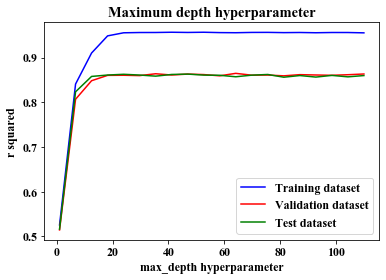

In [224]:
plt.plot(md, r2_train, "-b", label="Training dataset")
plt.plot(md, r2_valid, "-r", label="Validation dataset")
plt.plot(md, r2_test, "-g", label="Test dataset")
plt.legend(loc="lower right")

plt.title("Maximum depth hyperparameter")
plt.ylabel('r squared')
plt.xlabel('max_depth hyperparameter')
plt.show()

Finally, the selected model, the random forest regressor with is used to map depth along the lake.

In [21]:
def load_img_from_folder(folder):
    images = []
    names = []
    for filename in os.listdir(folder):
        img = tifffile.imread(os.path.join(folder,filename))
        names.append(filename)
        images.append(img)
    return images, names

path = '.'
images, names = load_img_from_folder('images')

In [81]:
mask = images[0]
img_shp = np.shape(mask)
bands = np.stack((images[1], images[2], images[3], images[4], images[5], images[6]), axis = 2)

ind = np.reshape(mask, (img_shp[0]*img_shp[1], 1))
input = np.reshape(bands, (img_shp[0]*img_shp[1], 6))
input = input/10000

In [84]:
nz_ind = np.nonzero(ind)

In [228]:
y_pred=np.zeros(len(ind))

for i in nz_ind:
    sample = input[i, :]
    y_samp = regr0.predict(sample)
    y_pred[i] = y_samp

In [99]:
depth = np.reshape(y_pred, (img_shp[0],img_shp[1]))

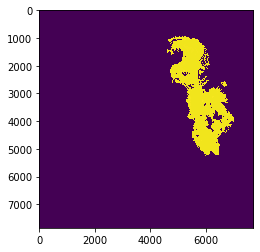

In [100]:
plt.imshow(depth)

In [111]:
value,position = min(((b,a) for a,b in enumerate(y_pred) if b>-99), default=(None,None))

value

0.026972848742527315

Finally, the produced image is saved to be able to plot and alalyze the results in ArcGIS.

In [17]:
import rasterio

ref_img = rasterio.open('./images/LC08_L1TP_169034_20180325_20180404_01_T1_sr_band2.tif')

ref_img.bounds

BoundingBox(left=362385.0, bottom=4029285.0, right=594315.0, top=4264815.0)

In [24]:
from rasterio.warp import calculate_default_transform

src = rasterio.open('./images/LC08_L1TP_169034_20180325_20180404_01_T1_sr_band2.tif')

In [19]:
#!pip install gdal

from osgeo import gdal

In [20]:
step1 = gdal.Open('./images/LC081690342018032501T1-SC20190406090751_MainWaterBody.tif', gdal.GA_ReadOnly)
GT_input = step1.GetGeoTransform()
step2 = step1.GetRasterBand(1)
img_as_array = step2.ReadAsArray()
size1,size2=img_as_array.shape
op =np.zeros(shape=(size1,size2))

In [21]:
#!pip install rioxarray
import rioxarray as rxr

In [22]:
step3 = rxr.open_rasterio('./images/LC081690342018032501T1-SC20190406090751_MainWaterBody.tif', masked=True)
dst_crs= step3.rio.crs

In [160]:
depth_proj = xr_dep.rio.set_crs(dst_crs, inplace=True)

In [161]:
tifffile.imsave('test2.tif', depth_proj)